<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/09_few-to-no-labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

# Chapter 9. 레이블 부족 문제 다루기

레이블링된 데이터가 전혀 없거나 매우 적은 경우에도 사용 가능한 방법

- 제로샷 학습(zero-shot learning)

- 퓨샷 학습(few-shot learning)

In [1]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=9)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 32.16 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.35.2
Using datasets v2.16.1
Using accelerate v0.26.1
Using nlpaug v1.1.11
Using skmultilearn
Using sacremoses v0.1.1


레이블링 데이터 비율에 따른 학습 방법 선택 전략

1. 레이블된 데이터가 있나요?

  - 레이블링된 데이터가 조금이라도 있다면, 가장 좋은 방법을 결정하는데 영향을 미침
  - 레이블링된 데이터가 전혀 없다면 종종 강력한 기준점을 세워주는 제로샷 학습을 추천

2. 레이블링된 데이터가 얼마나 있나요?

  - 레이블링된 데이터가 있다면, 그 다음에는 데이터의 양이 중요
  - 가용한 훈련 데이터가 많다면 미세 튜닝 방식 추천

3. 레이블링되지 않은 데이터가 있나요?

  - 분류기를 훈련하기 전에 레이블링되지 않은 데이터를 사용해 해당 도메인에서 언어 모델을 미세 튜닝하는 방법
  - 비지도 데이터 증식(UDA: Unsupervised Data Augmentation)
  - 불확실성 인지 자기 훈련(UST: Uncerntainty-aware self-training)
  등 다양한 복잡한 방법을 활용 가능

4. 레이블링된 데이터가 전혀 없다면?

   - 데이터를 레이블링해 늘릴 수 없음
   - 이 경우 퓨샷 학습이나 사전 훈련 언어 모델의 임베딩을 사용해 최근접 이웃 검색(Nearest Neighbor Search)로 룩업(lookup)을 수행할 수 있음

   

<img alt="decision-tree" caption="Several techniques that can be used to improve model performance in the absence of large amounts of labeled data" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_decision-tree.png?raw=1" id="decision-tree"/>

**[그림9-1]** 많은 양의 레이블링된 데이터가 없을 때 모델 성능을 향상하기 위해 사용하는 여러가지 기법


## 9.1 깃허브 이슈 태거 만들기

허깅페이스 트랜스포머스 저장소의 이슈 탭에 들어가면 아래와 같은 이슈가 보임

 - 깃허브 이슈는 제목, 설명, 이슈의 특징을 나타내는 일련의 태그 또는 레이블을 담고 있어 자연스럽게 지도 학습 작업으로 구성 가능
 - 이슈의 제목과 설명이 주어지면 한 개 이상의 레이블을 예측하는 방식
 - 이슈에 여러 개의 레이블을 할당할 수 있으므로 **다중 레이블 텍스트 분류**(multilabel text classification) 문제가 됨
    + 이 문제는 2장에서 본, 각 트윗에 하나의 감정만 할당하는 다중 분류 문제보다 어려움

<img alt="issue-example" caption="A typical GitHub issue on the Transformers repository" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_issue-example-v2.png?raw=1" id="issue-example"/>

**[그림9-2]** 허깅페이스 트랜스포머스 저장소에 등록된 전형적인 깃허브 이슈

### 9.1.1 데이터 다운로드하기

* 저장소의 이슈를 모두 다운로드하려면 깃허브 REST API (https://docs.github.com/en/rest?apiVersion=2022-11-28)에 있는 Issues 엔드포인트(endpoint) https://docs.github.com/en/rest/issues?apiVersion=2022-11-28#list-repository-issues 를 반복해 호출해야 함.

  - 이 엔드 포인트는 JSON 객체의 리스트를 반환함

  - 이 객체는 이슈 상태(오픈 또는 클로즈)와 이슈를 생성한 사람은 물론이고 [그림 9-2]에 있는 제목, 본문, 레이블 등 해당 이슈에 관한 많은 필드를 포함

* 모든 이슈를 다운로드하려면 시간이 걸리므로 깃허브 저장소에 미리 json 파일을 준비

  - 직접 다운로드 하고 싶다면 아래 fetch_issues() 함수 사용

### 이슈 다운로드 코드

직접 이슈를 다운로드하고 싶다면 파이썬에서 HTTP 요청을 처리하는 대표적인 라이브러리인 _Requests_ 를 사용해 Issues 엔드포인트를 호출할 수 있습니다. 다음은 허깅페이스 트랜스포머스 저장소의 이슈를 다운로드하는 함수입니다.

In [2]:
'''
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000,
                 rate_limit=5_000):
    batch = []
    all_issues = []
    per_page = 100     # 페이지마다 반환되는 이슈 개수
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"

    for page in tqdm(range(num_pages)):
        # 오픈 이슈와 클로즈 이슈를 모두 가져오기 위해 state=all로 쿼리합니다.
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
        batch.extend(issues.json())

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = []   # 다음 번 요청을 위해 비웁니다.
            print(f"깃허브 요청 한도에 도달했습니다. 한 시간 동안 중지합니다...")
            time.sleep(60 * 60 + 1)

    all_issues.extend(batch)
    df = pd.DataFrame.from_records(all_issues)
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)
'''

'\nimport time\nimport math\nimport requests\nfrom pathlib import Path\nimport pandas as pd\nfrom tqdm.auto import tqdm\n\ndef fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000,\n                 rate_limit=5_000):\n    batch = []\n    all_issues = []\n    per_page = 100     # 페이지마다 반환되는 이슈 개수\n    num_pages = math.ceil(num_issues / per_page)\n    base_url = "https://api.github.com/repos"\n\n    for page in tqdm(range(num_pages)):\n        # 오픈 이슈와 클로즈 이슈를 모두 가져오기 위해 state=all로 쿼리합니다.\n        query = f"issues?page={page}&per_page={per_page}&state=all"\n        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")\n        batch.extend(issues.json())\n\n        if len(batch) > rate_limit and len(all_issues) < num_issues:\n            all_issues.extend(batch)\n            batch = []   # 다음 번 요청을 위해 비웁니다.\n            print(f"깃허브 요청 한도에 도달했습니다. 한 시간 동안 중지합니다...")\n            time.sleep(60 * 60 + 1)\n\n    all_issues.extend(batch)\n    df = pd.DataFrame.from_

`fetch_issues()`를 호출할 때 깃허브의 시간 당 요청 횟수 제한을 넘기지 않도록 이슈를 여러 개의 배치로 다운로드합니다. 이 결과는 _github-issues-transformers.jsonl_ 파일에 저장됩니다. 이 파일의 한 라인은 하나의 이슈를 나타내는 JSON 객체입니다.

### 9.1.2 데이터 준비하기

다운로드한 모든 이슈를 판다스 데이터프레임으로 로드함

In [3]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"데이터프레임 크기: {df_issues.shape}")

데이터프레임 크기: (9930, 26)


이 데이터셋에는 거의 10,000개의 이슈가 있음

깃허브 API에서 어떤 정보를 가져왔는지 확인하기 위해 한 행을 출력

이 행에는 URL, ID, 날짜, 사용자, 제목, 본문, 레이블 같은 많은 필드가 포함됨

In [4]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


이 중 주목할 열은 labels 임

각 행마다 레이블에 대한 메타데이터로 구성된 JSON 객체의 리스트가 들어 있음

In [5]:
df_issues.loc[2, "labels"]

[{'id': 2659267025,
  'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1',
  'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed',
  'name': 'DeepSpeed',
  'color': '4D34F7',
  'default': False,
  'description': ''}]

목적상 각 레이블 객체의 name 필드에만 관심이 있으므로 labels 열을 레이블 이름으로 덮어 씀

In [6]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


이제 labels 열에 있는 각 행은 깃허브 레이블의 리스트가 됨

따라서 각 행의 길이를 계산해 할당된 레이블의 개수를 구할 수 있음

In [7]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


출력 결과를 보면, 대부분의 이슈는 레이블이 없거나 하나이며, 그 이상 있는 이슈는 적음

다음으로 데이터셋에서 가장 많이 등장한 상위 8개의 레이블을 확인
- 판다스에서는 labels 열에 explode() 메서드를 적용하면 리스트에 있는 각 레이블을 열로 변환
- 그 후 간단하게 value_counts()를 사용

In [8]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"레이블 개수: {len(df_counts)}")
# 상위 8개 레이블을 출력합니다.
df_counts.to_frame().head(8).T

레이블 개수: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


이 데이터셋에는 고유한 레이블이 65개 있고 클래스(레이블) 비율이 매우 불균형함

- wontfix와 model card가 가장 자주 등장함

분류 작업을 쉽게 만들기 위해 일부 레이블에 대한 태거(tagger)를 만듦

- 다음 코드로 데이터셋을 필터링해 앞으로 다룰 레이블만 남기고 읽기 쉽게 변환함


In [9]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

새로운 레이블에 대한 분포 확인

In [10]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


레이블이 없는 이슈를 별도의 훈련 세트로 다루면 도움이 됨

따라서 이슈에 레이블이 있는지 없는지를 나타내는 열도 새로 만듬

In [11]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [12]:
# 샘플 확인

for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit
tokenization step. While recent tokenization approaches based on data-derived
subword lexicons are less brittle than manually en

labels: ['new model']



이 이슈는 새로운 모델 구조를 제안

따라서 new model 태그가 적절함

title에 담긴 정보가 분류기에 유용하므로 body 필드에 있는 이슈 설명과 합침

In [13]:
df_issues["text"] = (df_issues
                     .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

데이터를 더 살펴보기 전에 drop_duplicates() 메서드로 중복된 데이터를 삭제

In [14]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"삭제된 중복 이슈: {(len_before-len(df_issues))/len_before:.2%}")

삭제된 중복 이슈: 1.88%


중복된 이슈가 조금 있지만 전체에서 차지하는 양은 적음

다른 장처럼 모델의 문맥 크기로 자를 때 너무 많은 정보를 잃지 않는지,

텍스트에 있는 단어 개수를 살펴보아 확인하는 것이 좋음

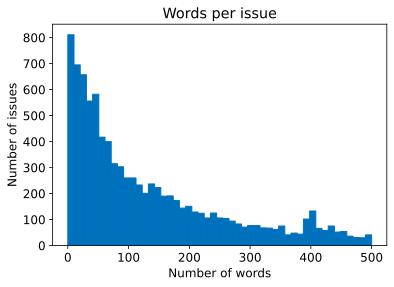

In [15]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len).hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

이 분포에는 많은 텍스트 데이터셋에서 보이는 롱테일(long tail) 특징이 있음

대부분의 텍스트가 매우 짧지만, 500 단어가 넘는 이슈도 있음

  - 특히 에러 메시지나 코드를 함께 포스팅하면 보통 이슈의 길이가 커짐
  - 대부분의 트랜스포머 모델의 문맥 크기는 512개 토큰이나 그 이상이기 때문에 일부 긴 이슈를 잘라내는 것이 전체 성능에 영향을 미칠 것 같지 않음

데이터셋을 살펴보고 정제했으니, 마지막으로 훈련 세트와 분류기를 평가할 검증 세트를 정의함

### 9.1.3 훈련 세트 만들기

모든 레이블에 대해 균형 잡힌 비율을 보장하지 못하기 때문에 다중 레이블 문제에서는 훈련 세트와 검증 세트를 만들기가 조금 까다로움

먼저 pytorch와 tokenization 같은 레이블을 모델이 처리 가능한 포맷으로 변환
이를 위해 사이킷런의 MultiLabelBinarizer 클래스 사용
- 이 클래스는 레이블 이름의 리스트를 받고 레이블에 해당하는 위치는 1, 나머지는 0인 벡터를 만듬


In [16]:
# 레이블 이름을 ID로 매핑하기 위해 all_labels 리스트에 MultiLabelBinarizer 클래스 적용

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

앞의 예에서 첫 번째 행은 두 개의 1을 포함
- 각각 new model과 tokenization 레이블에 해당
- 두번째 행은 pytorch 하나만 1


scikit-multilearn의 iterative_train_test_split() 함수를 사용해 이 데이터셋을 분할

이 함수는 레이블의 균형을 잡기 위해 반복적으로 훈련/테스트 세트를 만듦
- 이 함수를 DataFrame에 적용하기 위해 별도의 함수로 wrapping
- 2차원 특성 행렬을 기대하므로 분할하기 전에 인덱스 배열에 차원을 추가함

In [17]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

먼저 데이터를 지도 학습 데이터셋과 비지도 학습 데이터셋으로 나눔

그 다음 balanced_split() 함수를 사용해 지도 학습 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 균형 있게 분리

In [18]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

마지막으로 쉽게 데이터 셋을 토큰화하고 Trainer와 통합하기 위해 모든 분할을 담은 DatasetDict 객체를 생성

여기서는 from_pandas() 메서드를 사용해 판다스 DataFrame에서 각 분할을 바로 로드함

- balanced_split() 함수는 iterative_train_test_split()에 데이터프레임을 직접 전달하지 않고 인덱스만 전달
  + 이를 위해 열에 해당하는 차원을 추가해 2차원 배열로 만들어야 함. 그 다음 반환된 각 분할의 인덱스를 데이터 프레임의 iloc 메서드에 전달해 훈련 세트와 테스트 세트를 나눔.
  + 또 데이터 프레임 df에 레이블 열이 이미 포함되어 있으므로 iterative_train_test_split()에서 반환된 레이블 분할은 사용하지 않고 버림

In [19]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

마지막으로 분류기의 성능을 훈련 세트의 크기별로 평가하기 위해 훈련 슬라이스를 생성

### 9.1.4 훈련 슬라이스 만들기

적은 양의 레이블링된 데이터에서 얼마나 좋은 성능을 내는지 확인하기 위해 샘플 개수가 더 적은 훈련 데이터의 슬라이스를 생성
- iterative_train_test_split() 함수를 사용해 레이블마다 여덟 개 샘플로 시작해서 전체 훈련 세트를 담은 슬라이스까지 생성

In [20]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # 다음 슬라이스 크기를 채우는데 필요한 샘플을 분할합니다
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# 마지막 슬라이스를 포함하면 코랩의 경우 메모리 부족이 발생합니다.
# 대신 코랩 프로(https://colab.research.google.com/signup)를 사용하세요.
# 코랩을 사용하려면 다음 라인을 주석 처리하세요.
train_slices.append(all_indices), train_samples.append(len(ds["train"]))

train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

이런 반복적인 방식은 원하는 크기에 근사하게만 샘플을 나눔

주어진 크기에 맞는 균형 잡힌 분할을 구하는 것이 항상 가능하지는 않기 때문임

In [21]:
print("목표 분할 크기:")
print(train_samples)
print("실제 분할 크기:")
print([len(x) for x in train_slices])

목표 분할 크기:
[8, 16, 32, 64, 128, 223]
실제 분할 크기:
[10, 19, 36, 68, 134, 223]


시각화 시 목표 분할 크기를 x축으로 사용

## 9.2 나이브 베이즈 모델 만들기

베이스 라인 모델 설정의 필요성

1. 정규 표현식, 수동 규칙 또는 매우 간단한 모델을 기반으로 하는 기준 모델이 실제로 문제를 잘 해결하기도 함. 이 경우 트랜스포머와 같은 복잡한 모델을 사용할 필요가 없음

2. 복잡한 모델을 탐색할 때 기준 모델이 간단한 검증 역할을 수행함
  - 예를 들어 BERT-large 모델을 훈련하고 검증 세트에서 80% 정확도를 얻은 경우, 로지스틱 회귀와 같은 베이스 라인 모델의 분류기가 95%의 정확도를 달성했다면 끝까지 디버깅을 실시하는 노력을 추가하게 됨

여기서 사용한 베이스 라인 모델은 나이브 베이즈 분류기(Naive Bayes Classifier)임

- 이 모델은 간단하고 훈련 속도가 빠르며 입력의 변동에 매우 안정적
- scikit-multilearn 라이브러리르 사용해 이 문제를 OvR(One-versus-Rest) 분류 작업으로 변환
- 이 방식은 L개의 레이블을 위해 L개의 이진 분류기를 훈련


In [22]:
# 먼저 MultiLabelBinarizer 객체를 사용해 새로운 훈련 세트에 label_ids 열을 생성
# map() 함수를 사용해 모든 처리를 한 번에 수행함

def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

분류기 성능 평가는 마이크로, 매크로 F-1 스코어를 사용
- 마이크로 F-1 스코어는 자주 등장하는 레이블에 대한 성능을 추적하고
- 매크로 F-1 스코어는 빈도를 무시하고 모든 레이블에 대한 성능을 평균

각 모델을 다른 크기의 훈련 분할에서 평가할 것이므로 defaultdict로 각 분할의 점수를 담을 리스트를 생성

In [23]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

모델 훈련 및 훈련 평가 실시

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # 훈련 슬라이스와 테스트 데이터를 준비합니다
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # 간단한 CountVectorizer를 사용해 텍스트를 토큰 카운트로 인코딩합니다
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # 모델을 만들고 훈련합니다!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # 예측을 생성하고 평가합니다
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # 평가 결과를 저장합니다
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

코드 구동 원리

1. 훈련 슬라이스 준비 및 레이블 인코딩

2. CountVectorizer 사용 텍스트 인코딩

3. 단순하게 어휘사전 크기의 벡터를 생성
  - 이 벡터의 각 원소는 텍스트에 등장한 토큰의 빈도
  - 단어 순서 정보가 모두 없어지기 때문에 BoW(Bag-of-Words) 방식

4. 그 다음 분류기를 훈련하고 테스트 세트에서 예측을 만든 후에 classification_report() 함수를 사용해 마이크로와 매크로 f-1 점수를 측정

In [25]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

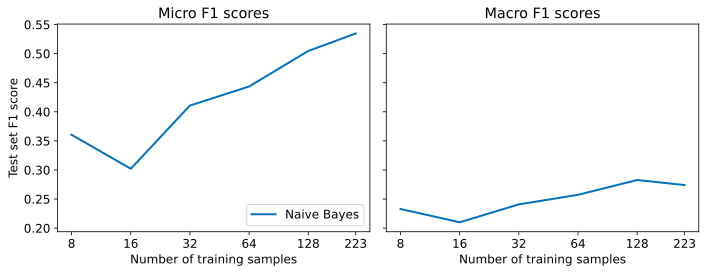

In [26]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

앞의 그래프는 샘플 개수를 로그 스케일로 표현

그래프를 보면 훈련 샘플개수의 증가에 따라 마이크로와 매크로 F-1 점수가 모두 향상

- 훈련 샘플이 너무 적으면 슬라이스 마다 클래스 분포가 달라져 결과에 약간의 잡음이 생성됨

## 9.3 레이블이 없는 데이터 다루기

레이블링된 데이터가 없는 경우 사용할 수 있는 첫번째 방법은

1. 제로샷 분류(zero-shot classification)

  - 제로샷 분류는 작업별 말뭉치에서 추가로 미세 튜닝하지 않고 사전 훈련된 모델을 사용하는 것이 목표
    + 이 방식을 잘 이해하려면 BERT와 같은 언어 모델이 수천 권의 책과 위키피디아의 대규모 덤프에서 텍스트에 있는 마스킹된 토큰을 예측하도록 사전 훈련됐다는 사실을 기억
    + 누락된 토큰을 잘 예측하려면 모델은 문맥에 있는 주제를 인식해야 함

  - 간단한 예시
    + 가령 두 아이가 있는데, 한 아이는 자동차 영화를 좋아하고 다른 아이는 동물 영화를 좋아함
    + 이미 개봉된 영화는 모두 봤으니, 새 영화의 주제가 어떤 것인지 알려주는 함수를 만들려고 함
    + 자연스럽게 이 작업에 트랜스포머를 사용
    

In [27]:
# 먼저, 마스크드 언어 모델을 사용해 마스킹된 토큰 내용을 예측하는 fill-mask 파이프라인에 BERT 베이스 모델을 로드함

from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

그 다음 약간의 영화 설명을 작성하고 마스킹된 단어를 위한 프롬프트를 추가

이 프롬프트는 모델이 분류하도록 안내하는 역할을 함

fill-mask 파이프 라인은 마스킹된 위치에 놓기에 가장 가능성이 높은 토큰을 반환함


In [28]:
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 animals:     0.103%
토큰 lions:       0.066%
토큰 birds:       0.025%
토큰 love:        0.015%
토큰 hunting:     0.013%


확실히 이 모델은 동물에 관한 토큰만 예측함

방식을 바꿔 가장 가능성이 높은 토큰을 얻는 대신 주어진 토큰에 대한 확률을 출력하도록 파이프라인을 실행

- 여기서는 cars와 animals를 선택해 타깃으로 파이프라인에 전달

In [29]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 animals:     0.103%
토큰 cars:        0.001%


당연히 cars 토큰에 대한 예측 확률은 animals 보다 훨씬 더 낮음

자동차에 관련된 설명에서도 잘 동작하는지 확인

In [30]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 cars:        0.139%
토큰 animals:     0.006%


위 예제는 사전 훈련된 모델을 추가 훈련없이 다른 작업에 적용하는 방법을 보여줌
- 이는 이 장에서 소개할 많은 방법들의 핵심 아이디어
- 이 예는 분류에 마스크드 언어 모델을 바로 사용하기 위해 마스킹된 프롬프트를 만듬

텍스트 분류에 좀 더 가까운 작업인 자연어 추론(Natural Language Inference)에서 미세 튜닝된 모델을 적용하면 결과가 더 좋은지 알아보겠음
- 분류할 때 마스크드 언어 모델을 사용하는 것이 좋지만, 좀 더 비슷한 작업에서 훈련된 모델을 사용하는 것이 더 좋을 때도 있음
- 바로 **텍스트 함의(text entailment)** 라는 작업
- 텍스트 함의에서는 모델이 두 개의 텍스트 구절이 서로 연결되는지 아니면 모순되는지 판단함
- 모델은 일반적으로 **MNLI**(Multi-Genre NLI) 말뭉치나 **XNLI**(Cross-Lingual NLI) 말뭉치 같은 데이터셋에서 함의와 모순을 감지하도록 훈련됨


이 데이터 셋에 있는 각 샘플은 전제(premise), 가설(hypotheis), 레이블(label) 세 부분으로 구성됨

- 레이블은 **entailment**, **neutral**, **contardiction** 중 하나임
  +  **(entailment 레이블)** 전제 조건하에서 가설 텍스트가 거짓이거나 부적합할때 사용됨
  + **(contradiction 레이블)** 전제 조건하에서 가설 텍스트가 거짓이거나 부적합할 때 사용됨
  + **(neutral 레이블)** 이런 두 경우에 해당하지 않으면 neutral 레이블이 할당됨






**[표 9-1]** MLNI 데이터셋에 있는 세 가지 클래스

|전제 | 가설 | 레이블 |
|:----|:-----|:------|
|His favourite color is blue. | He is into heavy metal music | **neutral** |
|She finds the joke hilarious. | She thinks the joke is not funny at all. | **contradiction**|
|The house was recently built. | The house is new. | **entailment** |


MLNI 데이터셋에서 훈련한 모델을 사용하여 어떤 레이블도 필요하지 않은 분류기를 만들수 있음! 핵심 아이디어는 분류하고자 하는 텍스트를 전제로 사용해 다음과 같은 가설을 만드는 것

"This example is about `{label}`."

`{label}`에는 클래스 이름을 넣음

함의 점수는 전제가 주제와 얼마나 관련되는지 알려줌

이를 여러 클래스에 순차적으로 실행함. 이 방식은 클래스마다 정방향 패스를 실행하므로 일반적인 분류기보다 덜 효율적.

또 레이블 이름 선택이 정확도에 큰 영향을 미치므로 이 점을 주의해야 함
대체로 의미 있는 이름을 선택하는 것이 좋음
- 예를 들어 레이블을 단순히 Class 1이라 하면 어떤 의미인지 모델이 알지 못하고 모순인지 함의 인지에 대한 힌트를 얻지 못함

In [31]:
# 허깅페이스 트랜스포머스에는 제로샷 분류를 위한 MLNI 모델이 내장됨
# 다음처럼 파이프라인을 사용해 초기화 함

from transformers import pipeline

# CPU에서 실행하려면 device=0을 삭제하세요.
pipe = pipeline("zero-shot-classification", device=0)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

- device=0으로 설정하면 추론 속도를 높이기 위해 기본 CPU 대신 GPU에서 모델을 실행함

- 텍스트를 분류하려면 레이블 이름과 함께 파이프라인에 전달됨

- milti_label=True로 지정하면 단일 레이블 분류를 위한 최댓값이 아니라 모든 점수가 반환됨

  + 단일 레이블의 반환 값은 클래스별 확률의 합이 1이 됨. 다중 레이블 분류에서는 여러 클래스의 확률이 1에 가까워지면 전체 확률의 합이 1을 넘을 수도 있음

In [32]:
sample = ds["train"][0]
print(f"레이블: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\n예측:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

레이블: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit tokeni

예측:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


**Note** 부분단어 토크나이저를 사용하므로 모델에 코드를 전달할 수도 있음! 제로샷 파이프라인을 위한 사전 훈련 데이터셋은 코드 비율이 적어서 토큰화가 덜 효율적일 때가 있음. 하지만 코드도 자연어로 구성되는 부분이 많아 큰 문제가 되지 않음
또 코드에 프레임워크(파이토치 또는 텐서플로) 같은 중요한 정보가 담기는 경우도 있음


모델은 텍스트의 주제가 신형 모델(new model)이라고 강하게 확신함

하지만 다른 레이블에도 비교적 높은 점수를 할당함. 제로샷 분류의 중요한 부분은 다루고 있는 도메인임
여기서 처리하는 텍스트는 매우 기술적이고 대부분 코딩과 관련된 내용이 담김
이는 MNLI 데이터셋에 있는 원랜 텍스트 분포와 매우 다름

따라서 당연히 이 작업은 모델에게 어려움

훈련 데이터와 얼마나 비슷한지에 따라 특정 도메인에서 더 잘 수행되기도 함


In [33]:
# 제로샷 파이프라인에 하나의 샘플을 주입하는 함수를 작성하고 이를 map() 메서드로 전체 검증 세트에 적용

def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


점수를 구했으니, 다음 단계로 샘플마다 어떤 레이블을 할당할지 결정.

이때 선택지는 두 가지

- 임곗값을 정의하고 이 임곗값을 초과한 모든 레이블을 선택
- 점수가 높은 순으로 상위 k개 레이블을 선택

In [34]:
# 두 방법을 비교하는 함수 활용

def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("`threshold` 또는 `topk`로 지정해야 합니다.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

그다음 예측 레이블을 사용해 사이킷런의 분류 리포트 결과를 반환하는 두 번째 함수 get_clf_report() 작성

In [35]:
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0,
        output_dict=True)

이 두 함수로 먼저 k를 증가시키면서 탑-k 방법을 적용

그 다음 검증 세트에 대한 마이크로 및 매크로 F-1 점수 시각화

In [36]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                    fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

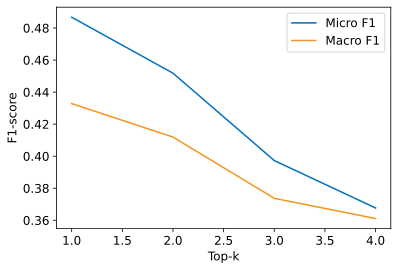

In [37]:
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

In [38]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

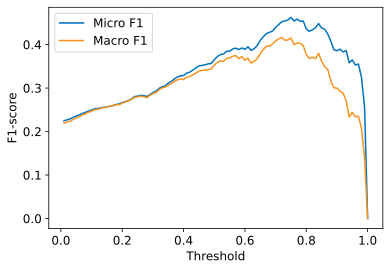

In [39]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [40]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'최상의 임곗값 (마이크로): {best_t}, F1-점수 {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'최상의 임곗값 (마크로): {best_t}, F1-점수 {best_macro:.2f}.')

최상의 임곗값 (마이크로): 0.75, F1-점수 0.46.
최상의 임곗값 (마크로): 0.72, F1-점수 0.42.


이 방식의 결과는 탑-1 결과보다 다소 나쁘지만, 그래프에 정밀도/재현율의 트레이드 오프(trade-off)가 확실하게 나타남. 임곗값을 매우 낮게 설정하면 예측이 매우 많아져 정밀도가 낮아짐

- 임계값을 매우 낮게 설정하면 예측이 매우 많아져 정밀도가 낮아짐
- 임계값을 매우 높게 하면 예측하기 어려워져 재현율이 낮아짐
- 이 그래프에서는 0.8 근방의 임곗값이 이 둘 사이의 최적값으로 보임

**탑-1 방법이 더 나은 결과를 냈으니 이를 사용해 테스트 세트에서 제로샷 분류와 나이브 베이즈를 비교**

In [41]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

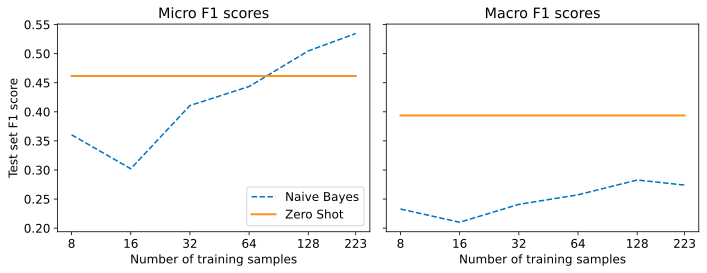

In [42]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

제로샷 파이프라인을 기준 모델과 비교하면 다음 두 가지를 관찰할 수 있음

1. 레이블링된 샘플이 50개보다 더 적다면 제로샷 파이프라인이 기준 모델의 성능을 쉽게 추월함

2. 샘플이 50개 이상이더라도 마이크로와 매크로 F-1 점수를 모두 고려하면 제로샷 파이프라인이 더 나음
  - 마이크로 F1 점수의 결과를 보면, 기준 모델이 빈도가 높은 클래스에서 잘 동작하지만 제로샷 파이프 라인은 학습할 샘플이 필요하지 않기 때문에 기준 모델보다 더 뛰어남


만약 자신의 데이터셋에서 좋은 결과를 얻기 힘들다면 제로샷 파이프라인의 성능 향상을 위해 몇 가지 방법을 시도 가능

- 파이프라인의 작동 방식은 레이블 이름에 매우 민감함. 이름이 무의미하거나 텍스트에 쉽게 연결되지 않으면 파이프라인이 제대로 동작하지 않음. 이름을 바꾸거나 여러 이름을 동시에 사용한 다음 후속 단계에서 결과를 집계

- 가설을 변형해도 성능이 높아짐. 기본적으로 가설은 `hypothesis="This is example is about {}"` 이지만 파이프라인에 다른 텍스트를 전달해도 됨. 문제에 따라 성능이 향상하기도 함

## 9.4 레이블이 적은 데이터 다루기

대부분의 NLP 프로젝트는 극소량이더라도 레이블링된 샘플이 있음.

레이블은 고객이나 다른 팀에서 바로 얻거나 샘플 몇 개에 직접 레이블을 입력함

이전 절의 방법을 사용하더라도, 제로샷 방식이 얼마나 잘 동작하는지 평가하려면 약간의 레이블리된 샘플이 필요함. 이 절에서 적은 레이블 데이터를 활용하는 방법을 확인(데이터 증식 기법을 비롯한)

### 9.4.1 데이터 증식

**데이터 증식(data augmentation)** 기법

- 기존 샘플에서 새 훈련 샘플을 생성하는 방법
- 간단하지만 효과적으로 성능을 높일 수 있음
- 컴퓨터 비전에서 데이터 증식은 일반적인 전략이지만 텍스트는 단어나 문자가 바뀌면 의미가 완전히 달라지기 때문에 데이터 증식이 조금 까다로움
  + 하지만 텍스트가 여러 문장으로 구성되었다면 이런 변형으로 추가되는 잡음은 대개 레이블에 영향을 미치지 않음
  

**데이터 증식 기법 종류**

1. 역 번역(back translation)

  - 원본 언어로 된 텍스트를 기계 번역을 사용해 하나 이상의 타깃 언어로 번역
  - 그 다음 이를 원본 언어로 다시 번역
  - 역번역은 데이터가 많은 언어 또는 도메인 특화된 언어가 매우 많지 않은 말뭉치에서 잘 동작하는 편

2. 토큰 섞기(token perturbations)

  - 훈련 세트의 한 텍스트에서 동의어 교체, 단어 추가, 교환, 삭제 같은 간단한 변환을 임의로 선택해 수행

3. 이 외 방법

  - 아래 표와 Amit Chaudhary의 블로그 포스트 "A Visual Survey of Data Augmentation in NLP" 참조 (https://amitness.com/2020/05/data-augmentation-for-nlp/)

**[표9-2]** 텍스트에서 사용할 수 있는 여러가지 데이터 증식 기법

|데이터 증식 | 문장 |
|:----------|:-----|
|없음       | Even if you defeat me Megatron, others will rise to defeat your tyarnny |
|동의어 교체| Even if you kill me Megatron, others will prove to defeat your tyranny |
|무작위 추가| Even if you defeat me Megatron, others humanity will rise to defeat your tyranny |
|무작위 교체| You even if defeat me Megatron, others will rise defeat to tyranny your |
|무작위 삭제| Even if you me Megatron, others to defeat tyranny |
|역 번역(독일어)| Even if you defeat me, others will rise up to defeat your tyranny |

In [43]:
# 동의어 교체를 위해 NlpAug의 ContextualWordEmbsAug 클래스로
# DistilBERT의 문맥 단어 임베딩을 사용

from transformers import set_seed
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

set_seed(3)
text = "Even if you defeat me Megatron, others will rise to defeat your tyranny"
augs = {}
augs["synonym_replace"] = naw.SynonymAug(aug_src='wordnet')
augs["random_insert"] = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased",
                                device="cpu", action="insert", aug_max=1)
augs["random_swap"] = naw.RandomWordAug(action="swap")
augs["random_delete"] = naw.RandomWordAug()
augs["bt_en_de"] = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de',
    to_model_name='facebook/wmt19-de-en'
)
for k,v in augs.items():
    print(f"원본 텍스트: {text}")
    print(f"{k}: {v.augment(text)}")
    print("")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

vocab-src.json:   0%|          | 0.00/849k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/315k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

vocab-src.json:   0%|          | 0.00/849k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/315k [00:00<?, ?B/s]

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
synonym_replace: ['Even if you vote down me Megatron, others will turn out to
defeat your tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_insert: ['even if you defeat me megatron, others will rise to finally
defeat your tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_swap: ['Even if you defeat Megatron me, others to will rise defeat your
tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_delete: ['Even if me Megatron, will rise to tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
bt_en_de: ['Even if you defeat me, others will rise up to defeat your tyranny']



In [44]:
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased",
                                device="cpu", action="substitute")

text = "Transformers are the most popular toys"
print(f"원본 텍스트: {text}")
print(f"증식된 텍스트: {aug.augment(text)}")

원본 텍스트: Transformers are the most popular toys
증식된 텍스트: ['transformers — the most coveted toys']


In [45]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += aug.augment(text)
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

텍스트 증식을 위한 augment_text 함수 생성

- 이 함수를 map() 메서드에 전달할 때 transformations_per_example 매개변수에 새로 생성할 샘플 수를 지정할 수 있음
- 이 함수를 사용하면 훈련 슬라이스를 선택한 후 코드 한 줄만 추가하여 나이브 베이즈 분류기를 훈련함

In [46]:
for train_slice in train_slices:
    # 훈련 슬라이스와 테스트 데이터를 준비합니다
    ds_train_sample = ds["train"].select(train_slice)
    # 증식 결과를 펼쳐서 레이블에 정렬합니다!
    ds_train_aug = (ds_train_sample.map(
        augment_text, batched=True, remove_columns=ds_train_sample.column_names)
                    .shuffle(seed=42))
    y_train = np.array(ds_train_aug["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # 간단한 CountVectorizer를 사용해 텍스트를 토큰 카운트로 인코딩합니다
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # 모델을 만들고 훈련합니다!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # 예측을 생성하고 평가합니다
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # 평가 결과를 저장합니다
    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

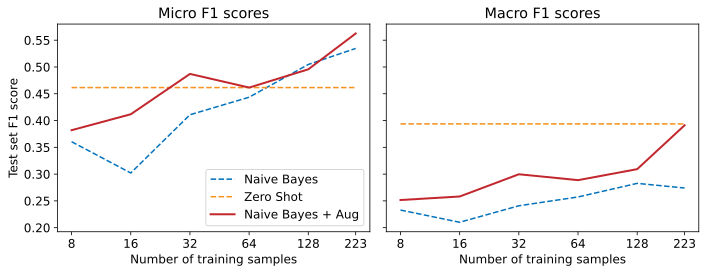

In [47]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

그림을 보면 소량의 데이터 증식으로 나이브 베이즈 분류기의 F1 점수가 약 5포인트 상승함

- 약 170개 훈련 샘플을 사용하면 매크로 점수에서 제로샷 파이프라인의 성능을 추월함


다음으로 대규모 언어 모델의 임베딩을 사용하는 방법을 확인

### 9.4.2 임베딩을 룩업 테이블로 사용하기

**이 절의 코드는 [09_few_to_no_labels_with_faiss.ipynb](https://github.com/rickiepark/nlp-with-transformers/blob/main/09_few_to_no_labels_with_faiss.ipynb) 노트북에 있습니다**

<img alt="nearest-neighbours" caption="An illustration of nearest neighbor embedding lookup" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_nearest-neighbours.png?raw=1" id="nearest-neighbours"/>

In [48]:
# 깃허브에서 09_few_to_no_labels_with_faiss.ipynb의 결과를 다운로드하여 점수 딕셔너리에 추가합니다.
!wget https://bit.ly/3QZRsHS -O 09_results_of_faiss.gz

import joblib

embedding_results = joblib.load('09_results_of_faiss.gz')
macro_scores["Embedding"] = embedding_results["macro"]["Embedding"]
micro_scores["Embedding"] = embedding_results["micro"]["Embedding"]

--2024-02-03 10:17:34--  https://bit.ly/3QZRsHS
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/nlp-with-transformers/raw/main/09_results_of_faiss.gz [following]
--2024-02-03 10:17:34--  https://github.com/rickiepark/nlp-with-transformers/raw/main/09_results_of_faiss.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-transformers/main/09_results_of_faiss.gz [following]
--2024-02-03 10:17:34--  https://raw.githubusercontent.com/rickiepark/nlp-with-transformers/main/09_results_of_faiss.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.git

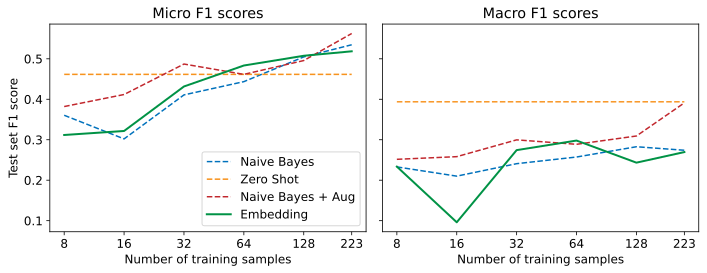

In [49]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

임베딩 룩업은 학습 가능한 파라미터 k와 m을 가지면서 마이크로 점수에서 이전 방법들에 비해 경쟁력이 있음
- 하지만 매크로 점수에서는 조금 나쁜 성능을 보임
- 이런 결과는 조심해서 받아들여야 함. 도메인에 따라 잘 동작하는 방법이 크게 다름

이 제로샷 파이프라인의 훈련 데이터는 여기서 사용한 깃허브 이슈 데이터셋과 많이 다름. 깃허브 이슈에는 모델이 이전에 만나본 적 없는 많은 코드가 포함됨
- 이 파이프라인은 리뷰 감성 분석같은 더 일반적인 작업에서 훨씬 더 잘 동작함
- 마찬가지로 임베딩의 품질은 모델과 훈련하는 데이터에 따라 달라짐
  + 다른 모델을 테스트하려면 모델 체크포인트 이름만 바꾸면 되므로, 평가 파이프라인을 준비하고 나면 여러 모델을 빠르게 시험할 수 있음

### 사이드바: FAISS를 사용한 효율적인 유사도 검색

- FAISS 라이브러리의 작동 방식과 ML 도구상자에서 이 라이브러리가 강력한 이유를 간략하게 설명

우리는 위키피디아와 같은 대규모 데이터셋이나 구글 같은 검색 엔진으로 웹에서 빠른 텍스트 쿼리를 수행하는데 익숙함
- 이 성능은 텍스트에서 임베딩으로 바꿀 때도 유지하고 싶지만 텍스트 쿼리의 속도를 높이는 방법이 임베딩에는 적용되지 않음

텍스트 검색의 속도를 높이기 위해서는 일반적으로 단어를 문서에 매핑한 역 인덱스(inverted index)를 만듦
- 역 인덱스는 책 끝에 있는 찾아보기와 비슷하게 동작함
  - 즉, 각 단어는 단어가 등장한 페이지(이 경우, 문서)에 매핑됨
  - 나중에 쿼리를 실행하면 검색 단어가 등장한 문서를 빠르게 찾음
- 이 방식은 단어와 같은 이산적인 객체에서 잘 동작함

하지만 벡터와 같은 연속적인 객체에서는 잘 맞지 않음. 각 문서의 벡터는 고유할 가능성이 높아 인덱스가 새로운 벡터와 절대 일치하지 않음. 따라서 정확히 일치하는 항목 대신 가깝거나 비슷한 항목을 찾아야 함

데이터베이스에서 쿼리 벡터와 가장 비슷한 벡터를 찾고 싶을 때는 이론적으로 쿼리 벡터를 데이터베이스에 있는 n개의 벡터와 모두 비교해야 함. 작은 데이터셋에서는 문제가 안되지만, 이를 수천 또는 수백만 개 항목으로 확장한다면 쿼리가 처리되는 동안 잠시 기다려야 함

**FAISS**는 몇가지 트릭으로 이 문제를 해결함
- 주요 개념은 데이터셋을 분할하는 것
- 쿼리 벡터를 데이터셋 일부와 비교하면 처리 속도가 크게 높아짐.
- 데이터셋이 무작위로 나뉘면 K-means clustering을 적용하여 유사도에 따라 임베딩을 그룹으로 묶음
  + 각 그룹에 속한 벡터를 모두 평균해 센트로이드(centroid) 벡터를 얻음 (**[그림 9-4]**)



<img alt="faiss-index" caption="The structure of a FAISS index: the gray points represent data points added to the index, the bold black points are the cluster centers found via k-means clustering, and the colored areas represent the regions belonging to a cluster center" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_faiss-index.png?raw=1" id="faiss-index"/>

**[그림 9-4]** FAISS 인덱스의 구조

- 회색 점은 인덱스에 추가된 데이터 포인트
- 검은 동그라미는 k-평균 클러스터링으로 찾은 클러스터 센트로이드
- 음영으로 구분된 지역은 하나의 클러스터 중심에 속한 영역


이렇게 그룹핑되면 n개의 벡터에서 검색하기가 훨씬 쉬어짐.

1. 먼저 k개의 센트로이드에서 쿼리와 가장 비슷한 것을 찾음(k회 비교)

2. 그 다음 해당 그룹 안에서 검색을 함($n/k$개 원소 비교)

3. 그러면 비교 횟수가 n에서 $k + n/k$ 으로 줄어듬

  - 최소값은 $k = \sqrt{n}$


데이터셋 분할로 쿼리 속도를 높이는 것 외에도 FAISS의 속도 향상을 높이는 방법으로 GPU를 활용할 수 있음

- FAISS를 사용하는 가장 큰 프로젝트 소개
  + 페이스북 CCMatrix (https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index)

    * 다국어 임베딩을 사용해 다른 언어에서 동일한 문장을 찾음
    * 이 거대한 말뭉치는 100개 언어를 직접 번역하는 대규모 기계 번역 모델인 M2M100을 훈련하는데 사용됨
      
      +  https://huggingface.co/facebook/m2m100_1.2B

### 사이드바 끝

### 9.4.3 기본 트랜스포머 미세 튜닝하기

레이블링된 데이터가 있다면 사전 훈련된 트랜스포머 모델의 미세 튜닝도 가능함
기본 BERT 체크포인트로 시작해 언어 모델의 미세 튜닝이 성능에 미치는 영향을 살펴 봄

**TIP** 많은 애플리케이션에서 사전 훈련된 BERT 같은 모델로 시작하는 것이 좋음. 하지만 말뭉치의 도메인이 사전 훈련된 말뭉치(일반적으로 위키피디아)와 크게 다르다면 허깅페이스 허브에 있는 많은 모델을 찾아봐야 함. 누군가가 이미 해당 도메인에서 모델을 사전 훈련했을 가능성이 있음!

In [50]:
# 1. 사전 훈련 토크나이저 로드 후 데이터셋 토큰화
#    + 훈련과 평가에 필요 없는 열 삭제

import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

다중 레이블 손실 함수는 이산적인 레이블 대신 클래스 확률도 사용할 수 있기 때문에 실수 타입의 레이블을 기대함

따라서 label_ids 열의 타입을 바꿔야 함

열 원소의 포맷을 바꾸면 애로우의 타입 포맷(typed format)에서 잘 동작하지 않으므로 조금 돌아가야 함

1. 먼저 레이블로 새 열을 만듦
2. 이 열의 포맷은 첫 번째 원소로 추론
3. 그 다음 원본 열을 삭제하고 새 열의 이름을 바꿔 원본 열을 대체함

In [51]:
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)},
                    remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

크기가 작기 때문에 훈련 데이터에 금세 과대 적합될 가능성이 높음. 따라서 load_best_model_at_end = True로 설정해서 마이크로 F-1 점수를 기반으로 최선의 모델을 선택함

In [52]:
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir="./results",
    num_train_epochs=20,
    learning_rate=3e-5,
    lr_scheduler_type='constant',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=32,
    weight_decay=0.0,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='micro f1',
    save_total_limit=1, log_level='error')

최상의 모델을 선택하려면 F-1 점수가 필요함.

따라서 평가 단계에서 이를 계산함
모델이 로짓을 반환하므로 먼저 시그모이드 함수로 예측을 정규화하고, 그 다음 간단한 임곗값으로 이를 이진화함

그 후 분류 리포트를 사용해 관심 대상 점수를 반환함


In [53]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)

    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                     zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
            "macro f1": clf_dict["macro avg"]["f1-score"]}

이제 훈련 준비가 완료됨

훈련 세트 슬라이스마다 처음부터 분류기를 훈련하고, 훈련 루프 끝에서 최상의 모델을 로드하고, 테스트 세트의 결과를 저장함

In [54]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [55]:
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model, tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],)

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

{'loss': 0.6565, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5977675914764404, 'eval_micro f1': 0.15023474178403753, 'eval_macro f1': 0.031189083820662766, 'eval_runtime': 0.2519, 'eval_samples_per_second': 420.769, 'eval_steps_per_second': 15.878, 'epoch': 1.0}
{'loss': 0.5732, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5564495325088501, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.2493, 'eval_samples_per_second': 425.217, 'eval_steps_per_second': 16.046, 'epoch': 2.0}
{'loss': 0.5353, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.5182487368583679, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.2448, 'eval_samples_per_second': 432.958, 'eval_steps_per_second': 16.338, 'epoch': 3.0}
{'loss': 0.4908, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.4819734990596771, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.247, 'eval_samples_per_second': 429.138, 'eval_steps_per_second': 16.194, 'epoch': 4.0}
{'loss':

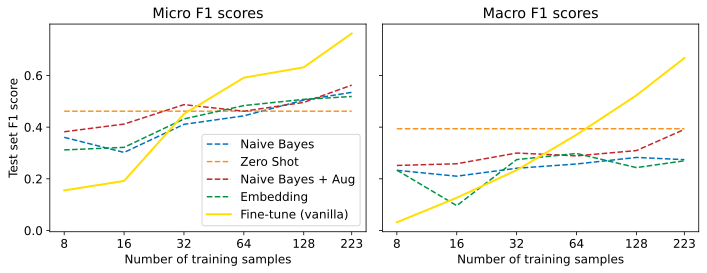

In [56]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

기본적인 BERT 모델을 간단하게 미세 튜닝해 64개 샘플에서 경쟁력 있는 모델을 얻음.

 - 모델을 훈련한 작은 샘플의 레이블이 일부 불균형하기 때문에 약간 불규칙한 행동을 보인다는 사실도 알게 됨

 레이블링되지 않은 데이터셋을 사용하기 전에, 퓨샷 도메인 분야에서 언어 모델을 사용할 또 다른 유망한 방법을 빠르게 살펴봄

### 9.4.4 프롬프트를 사용한 인-컨텍스트 학습과 퓨-샷 학습

이 장의 앞 부분에서 BERT나 GPT-2 같은 언어 모델을 사용해 지도 학습에 적용함.
- 이를 위해 프롬프트를 사용하고 모델의 토큰 예측을 파싱함
- 이 방식은 작업에 특화된 헤드를 추가하고 모델 파라미터를 작업에 맞게 튜닝하는 전통적인 방식과 다름
  + 훈련 데이터가 전혀 필요하지 않은 장점과 가지고 있는 레이블링된 데이터를 활용할 수 없는 단점이 있음

그 절충안으로 **인-컨텍스트 학습(in-context learning)** 또는 **퓨샷 학습(few-shot learning)**을 활용하는 방법도 있음




In [57]:
prompt = """\
Translate English to French:
thanks =>
"""

이 프롬프트는 모델이 단어 'merci'를 예측하도록 유도함. - 6장에서 요약을 위해 GPT-2를 사용할 때 텍스트에 'TL;DR'을 추가해서 모델이 텍스트로 명시적 훈련을 받지 않고도 요약을 생성하도록 유도함

GPT-3 논문에서 흥미로운 점은 프롬프트가 있는 샘플에서 효과적으로 학습하는 대규모 언어 모델의 능력임
- 앞의 번역 샘플에 영어-프랑스어 번역 샘플 몇 개를 보강하면 모델이 작업에서 더 뛰어난 성능을 냄
- 게다가 저자들은 모델이 인-컨텍스트 샘플을 더 잘 사용해 성능이 크게 향상됨을 알게 됨
- GPT-3 정도 크기의 모델을 실전 제품에 사용하기가 어렵지만, 이는 새롭게 부상하는 연구분야이며, 자연어로 명령을 입력하고 GPT-3가 파싱해 명령을 셸에 전달하는 자연어 셸 같은 멋진 애플리케이션을 만듬

---

레이블링된 데이터를 사용하는 또 다른 방법으로 프롬프트 샘플과 원하는 예측을 만들고 이런 샘플로 언어 모델을 계속 훈련하는 방법이 있음
- 이 방식을 따르는 ADAPET이란 이름의 새 방법은 생성된 프롬프트로 모델을 튜닝해 다양한 작업에서 GPT-3를 능가하는 성능 보여줌
- 이 방식은 사용자 헤드를 미세 튜닝하는 것보다 더 데이터 효율적일 수 있음




## 9.5 레이블링되지 않은 데이터 활용하기

**도메인 적응(domain adaption)**

- 언어 모델을 밑바닥부터 재훈련하는 대신 주어진 도메인의 데이터에서 계속 훈련하는 방법
- 이 단계에서는 마스킹된 단어를 예측하는 고전적인 언어 모델의 목표를 사용
  + 레이블링된 데이터가 필요하지 않음
  + 적응된 모델을 분류기로 로드하고 미세튜닝해서 레이블링되지 않은 데이터를 활용


  이제 사전 훈련된 언어 모델을 미세튜닝할 때 거쳐야 할 단계를 알아봄

### 9.5.1 언어 모델 미세 튜닝하기

마스크드 언어 모델링으로 사전 훈련된 BERT 모델을 레이블링이 없는 데이터셋에서 미세 튜닝함
- 데이터 토큰화 추가 단계
- 특별한 데이터 콜레이터

토크나이저는 텍스트에 있는 일반적인 토큰 외에 분류와 다음 문장 예측에 사용할 [CLS]와 [SEP] 같은 특스 토큰도 시퀀스에 추가함
- 마스크드 언어 모델링에서는 이런 토큰도 예측하도록 모델을 훈련하지 않음 -> 이런 이유도 손실을 계산할 때 특수 토큰을 마스킹함
- 이 외 return_special_tokens_mask = True로 설정해 토큰화할 때 마스크를 얻을 수 있음

In [58]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                     max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

마스크드 언어 모델링을 시작하려면 입력 시퀀스에 있는 토큰을 마스킹하고 출력에서 타깃 토큰을 마련하는 메커니즘이 필요함
- 이를 위해 랜덤한 토큰을 마스킹하고 시퀀스를 위해 레이블을 생성하는 함수를 작성
- 하지만 데이터셋에 타깃 시퀀스도 저장해야 하기 때문에 데이터셋의 크기는 두 배가 되면, 에포크마다 동일한 시권스 마스킹을 사용하게 됨

---

반면 데이터 콜레이터를 사용하는 방식은 더 우아함

**(데이터 콜레이터)** 데이터셋과 모델 호출 사이를 연결하는 함수
- 배치는 데이터셋에서 샘플링되고 데이터 콜레이터는 배치에 있는 원소를 모델에 주입하기 위해 준비함
- 가장 간단한 예는 각 원소의 텐서를 하나의 텐서로 연결하는 경우
- 여기서는 동적으로 마스킹과 레이블 생성을 수행하기 위해 데이터 콜레이터를 사용함

이런 방식에서는 레이블을 저장할 필요가 없고 샘플링할 때마다 새 마스크를 얻음
- 이런 작업을 위한 데이터 콜레이터는 **DataCollatorForLanguageModeling**을 사용
  + 모델의 토크나이저와 마스킹할 토큰 비율을 mlm_probability 매개변수에 지정해 초기화함
  + BERT 논문에 따라 이 콜레이터로 토큰의 15%를 마스킹함
  

In [59]:
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15)

DataFrame으로 결과를 빠르게 확인하기 위해 토크나이저와 데이터 콜레이터의 반환 포맷을 넘파이로 바꿈

In [60]:
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
original_input_ids = inputs["input_ids"][0]
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])
masked_input_ids = outputs["input_ids"][0]

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(original_input_ids),
    "Masked tokens": tokenizer.convert_ids_to_tokens(masked_input_ids),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Original input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


느낌표에 해당하는 토큰이 마스킹 토큰으로 바뀜
- 데이터 콜레이터가 레이블 배열을 반환함
  - 이 배열에서 원본 토큰은 -100이고 마스킹된 토큰의 경우는 토큰 ID임
  + 이전에 보았듯 -100에 해당하는 항목은 손실을 계산할 때 무시됨
  
다시 데이터 콜레이터의 포맷을 파이토치로 바꿈

In [61]:
data_collator.return_tensors = "pt"

토크나이저와 데이터 콜레이터가 있으니 마스크드 언어 모델을 미세 튜닝할 준비가 됨

- 이전처럼 TrainingArguments와 Trainer 설정

In [62]:
from huggingface_hub import notebook_login

notebook_login()

In [64]:
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=16, push_to_hub=True, log_level="error", report_to="none")

trainer = Trainer(
        model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
        tokenizer=tokenizer, args=training_args, data_collator=data_collator,
        train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"])

trainer.train()

{'loss': 2.1081, 'learning_rate': 4.6875e-05, 'epoch': 1.0}
{'eval_loss': 1.6857380867004395, 'eval_runtime': 0.7784, 'eval_samples_per_second': 286.47, 'eval_steps_per_second': 35.969, 'epoch': 1.0}
{'loss': 1.6343, 'learning_rate': 4.375e-05, 'epoch': 2.0}
{'eval_loss': 1.3655192852020264, 'eval_runtime': 0.7871, 'eval_samples_per_second': 283.316, 'eval_steps_per_second': 35.573, 'epoch': 2.0}
{'loss': 1.4792, 'learning_rate': 4.0625000000000005e-05, 'epoch': 3.0}
{'eval_loss': 1.4229965209960938, 'eval_runtime': 0.811, 'eval_samples_per_second': 274.964, 'eval_steps_per_second': 34.525, 'epoch': 3.0}
{'loss': 1.3974, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.0}
{'eval_loss': 1.4269212484359741, 'eval_runtime': 0.8029, 'eval_samples_per_second': 277.733, 'eval_steps_per_second': 34.872, 'epoch': 4.0}
{'loss': 1.343, 'learning_rate': 3.4375e-05, 'epoch': 5.0}
{'eval_loss': 1.2746531963348389, 'eval_runtime': 0.7781, 'eval_samples_per_second': 286.589, 'eval_steps_per_second

TrainOutput(global_step=4656, training_loss=1.2835331225313271, metrics={'train_runtime': 1254.2395, 'train_samples_per_second': 118.676, 'train_steps_per_second': 3.712, 'train_loss': 1.2835331225313271, 'epoch': 16.0})

In [65]:
trainer.push_to_hub("Training complete!")

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/youngbreadho/bert-base-uncased-issues-128/commit/da0c316f59d7e55c9f99ec3633d9cee5d720640f', commit_message='Training complete!', commit_description='', oid='da0c316f59d7e55c9f99ec3633d9cee5d720640f', pr_url=None, pr_revision=None, pr_num=None)

모델의 훈련 손실과 검증 손실을 보기 위해 Trainer의 로그 기록을 확인
- 모든 로그는 딕셔너리의 리스트로 trainer.state.log_history에 저장되어 쉽게 판다스 DataFrame으로 로드됨
- 훈련과 검증 손실이 다른 간격으로 기록되기 떄문에 데이터 프레임에 누락된 값이 있음 => 시각화 전 삭제


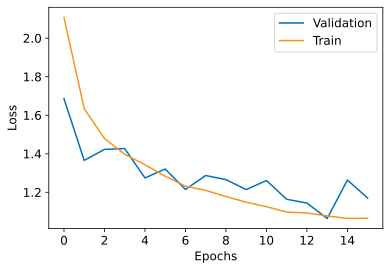

In [66]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
 .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

훈련 손실과 검증 손실이 모두 상당히 줄어든 것을 확인함

따라서 이 모델을 기반으로 분류기를 미세 튜닝해 성능이 올라가는 것을 확인!

### 9.5.2 분류기 미세 튜닝하기

앞서 만든 체크포인트를 조금 다르게 로드하고 미세 튜닝 과정을 반복함

In [67]:
model_ckpt = f'{model_ckpt}-issues-128'
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],
    )

    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    # DA는 도메인 적응을 의미합니다
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

{'loss': 0.6372, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5692640542984009, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.2465, 'eval_samples_per_second': 429.938, 'eval_steps_per_second': 16.224, 'epoch': 1.0}
{'loss': 0.5231, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.48763981461524963, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.2406, 'eval_samples_per_second': 440.532, 'eval_steps_per_second': 16.624, 'epoch': 2.0}
{'loss': 0.4379, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.44184383749961853, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.2599, 'eval_samples_per_second': 407.877, 'eval_steps_per_second': 15.392, 'epoch': 3.0}
{'loss': 0.3935, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.4090349078178406, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.2493, 'eval_samples_per_second': 425.155, 'eval_steps_per_second': 16.044, 'epoch': 4.0}
{'loss': 0.3567, 'learning_rate': 3e-0

기본 BERT를 기반으로 미세 튜닝한 결과를 비교하면 특히 데이터가 부족한 도메인에서 유리함

- 레이블링된 데이터가 더 많은 상황에서는 몇 퍼센트 포인트가 향상됨

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")

이는 도메인 적응이 레이블링되지 않은 데이터와 약간의 노력을 통해 모델 성능을 조금 향상시킬 수 있다는 사실을 잘 보여줌

### 9.5.3 고급 방법

레이블링 되지 않은 데이터를 활용하는 몇 가지 트릭의 추가적 소개

#### 비지도 데이터 증식

**비지도 데이터 증식(unsupervised data augmentation, UDA)**

레이블링되지 않은 샘플과 살짝 왜곡된 샘플에 대해 모델의 예측이 일정해야 한다는 것
- 왜곡은 토큰 교체나 역 번역 같은 표준적인 데이터 증식 전략으로 만들게 됨
- 그 다음 원본 예측과 왜곡된 샘플의 예측 사이에 KL 발산을 최소화하도록 일관성이 강제로 부여됨
- 이 과정이 아래 그림 9-5에 나타나 있음
- 레이블링되지 않은 샘플에 대한 항으로 크로스 엔트로피 손실을 보강해 일관성에 대한 요구사항을 통합함
  - 즉, 표준적인 지도학습 방식으로 레이블링된 데이터에서 모델을 훈련하지만 레이블링되지 않은 데이터에서 일관된 예측을 만들도록 모델을 제한함


<img alt="uda" width="600" caption="Training a model M with UDA (courtesy of Qizhe Xie)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_uda.png?raw=1" id="uda"/>   

**[그림 9-5]** UDA로 모델 M을 훈련하기

이 방식은 매우 인상적인 성능을 선보임

- 약간의 레이블링된 샘플을 사용해 UDA로 훈련한 BERT 모델이 수천 개의 샘플로 훈련한 모델과 비슷한 성능을 냄
- 하지만 데이터 증식 파이프라인이 필요하다는 단점이 있음
- 또 레이블링되지 않은 샘플과 증식 샘플에 대해 예측을 만들기 위해 여러 번 정방향 패스를 실행해야 하므로 훈련이 훨씬 오래 걸림


#### 불확실성 인지 자기 훈련

**불확실성 인지 자기 훈련(uncertainty-aware self-training, UST)**도 레이블링되지 않은 데이터를 활용하는 유망한 방법임
- 이 방법은 레이블링된 데이터에서 티처 모델을 훈련하고 이 모델을 사용해 레이블링되지 않은 데이터에서 의사 레이블(pseudo-label)을 만든다는 개념에 기초함
- 스튜던트 모델은 의사 레이블 데이터에서 훈련되고, 훈련 후에는 다음 반복에서 티처가 됨

이 방법에서 의사 레이블을 생성하는 방법이 흥미로움
- 모델 예측의 불확실성을 측정하기 위해 동일한 입력을 드롭아웃이 적용된 모델에 여러 번 주입함
- 이런 예측의 분산이 특정 샘플에 대한 모델의 불확실성을 대변함
- 이런 불확실성 측정값으로 **BALD(Bayesian Active Learning by Disagreement)**라는 방법을 사용해 의사 레이블을 샘플링함

---

전체 훈련 파이프 라인은 아래 그림과 같음

<img alt="ust" width="600" caption="The UST method consists of a teacher that generates pseudo-labels and a student that is subsequently trained on those labels; after the student is trained it becomes the teacher and the step is repeated (courtesy of Subhabrata Mukherjee)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_ust.png?raw=1" id="ust"/>

**[그림 9-6]** UST 방법은 의사 레이블을 생성하는 티처와 이 레이블에서 훈련되는 스튜던트로 구성됨

- 스튜던트가 훈련된 후 티처가 되는 과정이 반복됨

- 티처는 이런 반복 구조를 통해 지속적으로 의사 레이블을 만드는 데 능숙해지므로 모델 성능이 향상됨. 결국 이 방식은 수천 개인 전체 훈련 데이터에서 훈련된 모델의 몇 퍼센트 안에 들며 심지어 여러 데이터셋에서 **UDA**를 능가함

## 결론

이 장에서 레이블이 전혀 없거나 조금만 있는 경우라도 모델을 만드는 방법이 있다는 것을 확인함
- BERT 언어 모델이나 파이썬 코드에서 훈련된 GPT-2처럼 다른 작업에서 사전 훈련된 모델으 활용해 새로운 깃허브 이슈 분류 작업에서 예측을 만드는 방법
- 일반적인 분류 헤드를 가진 모델을 훈련할 때 도메인 적응을 사용해 추가적으로 성능을 향상시킬 수 있음


가장 잘 맞는 방법을 찾으려면 평가 파이프라인을 준비하고 빠르게 반복해 보는 것이 좋음
- 허깅페이스 트랜스포머스의 유연한 API를 사용하면 여러 모델을 빠르게 로드하고 코드 수정 없이 모델을 비교할 수 있음
- 허깅페이스 허브에는 만 개가 넘는 모델이 있음. 이전에 누군가가 비슷한 문제를 다뤘을 가능성이 다분함.
---


